# Proyecto Natural Language Processing (NLP):

In [1]:
# Librería para la declaración y uso de Data Frames:
import pandas as pd

# Librería para la utilización de Expresiones Regulares:
import re

# Librería para la utilización de herramientas para NLP:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords');
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet');

# Librería para mostrar la varra de progreso de bucles y funciones:
from tqdm import tqdm
tqdm.pandas();

# Librería para generar la nube de palabras:
from wordcloud import WordCloud

# Librería para poder generar gráficos:
import matplotlib.pyplot as plt

# Librería para poder realizar la partición entre train y test set:
from sklearn.model_selection import train_test_split

# Librería útil para realizar la conversión de palabras a vectores:
from sklearn.feature_extraction.text import TfidfVectorizer

# Librería para contruir una SVM:
from sklearn.svm import SVC

# Librería para utilizar modelos de optimización de hiperparámetros:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Librería para obtener las métricas de las predicciones:
from sklearn.metrics import classification_report, accuracy_score

# Librería para poder obtener valores aleatorios enteros:
from scipy.stats import randint, uniform


[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Paso 1 - Lectura de Datos: 

En primer lugar, es necesario **leer y guardar la información** en una variable para poder empezar a trabajar con ella.

Para ello, se ha guaradado el archivo con todos los datos en la ruta: */workspaces/NLP-clara-ab/data/raw/url_spam.csv* y se ha cargado en un Data Frame:

In [28]:
# Lectura del CSV con los datos, dada la ruta donde se guarda el archivo (se ha evitado cargar la primera columna con los índices de las filas):
df = pd.read_csv ('/workspaces/NLP-clara-ab/data/raw/url_spam.csv', sep = ",");

# Configuración de pandas para mostrar todas las columnas del DataFrame sin truncarlas al visualizarlo:
pd.set_option('display.max_columns', None);

# Se muestran las 5 primeras filas del Data Frame:
df.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


Una vez se ha cargado correctamente la información en el Data Frame df es interesante evaluar la **cantidad de información que se tiene**. Para ello, se recurre al atributo `shape` del Data Frame:

In [29]:
# Se utiliza el atributo shape del Data Frame para conocer cuánta información está cargada:
print(f" El archivo cargado contiene {df.shape[0]} URLs"); 

 El archivo cargado contiene 2999 URLs


Además, tal y como se ha visto en el **breve resumen** mostrado a partir de `.head()` la variable a predecir, `is_spam` tiene dos valores posibles: `True` or `False`. 

En este caso, nos interesa predecir si una URL es SPAM, es decir, **detectar el `TRUE`**. Por lo que se va a realizar un cambio de forma que, en todas las filas donde la columna `is_spam` sea `True`, se convertirán a `1` y donde haya un `False` se convertirán a `0`. 

Para no tener problemas, es importante comprobar, primero el **tipo de variable** que se encuentra en la columna `is_spam`:

In [30]:
# Se imprimen los tipos de variables de las dos columnas del DataFrame:
print(df.dtypes)

url        object
is_spam      bool
dtype: object


Ahora que se sabe que es un **boolean**, se puede realizar la conversión con la función `map()` de forma segura:

In [31]:
# Se codifica la columna objetivo:
df['is_spam'] = df['is_spam'].astype(bool).map({True: 1, False: 0})

# Se comprueba que se ha codificado correctamente: 
df.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,1
1,https://www.hvper.com/,1
2,https://briefingday.com/m/v4n3i4f3,1
3,https://briefingday.com/n/20200618/m#commentform,0
4,https://briefingday.com/fan,1


## Paso 2 - Análisis Exploratorio de Datos (Previo):

Antes de pasar el preprocesado de texto, donde se prepara al conjunto de datos para el análisis, es necesario realizar un **análisis exploratorio de los datos previo** de forma que se puedan **eliminar redundancias o datos faltantes** y no trabajar sobre ellos de forma innecesaria en el paso siguiente. 


### Paso 2.1 - Análisis de Duplicados:

In [32]:
# Se utiliza el método .duplicated() para identificar las URL repetidas dentro del DataFrame:
print(f" Hay un total de {df.duplicated().sum()} URLs duplicadas.");

 Hay un total de 630 URLs duplicadas.


Se han encontrado un total de 630 URLs duplicadas que se deben eliminar:

In [33]:
# Se eliminan los duplicados:
df_clean = df.drop_duplicates();

# Se comprueba que ya no quedan duplicados:
print(f" Hay un total de {df_clean.duplicated().sum()} URLs duplicadas.");

 Hay un total de 0 URLs duplicadas.


### Paso 2.2 - Análisis de Nulos:

In [34]:
# Se comprueba el porcentaje de filas que presentan al menos un valor nulo:
print(f" El {round(df_clean.isnull().any(axis=1).mean()*100, 2)} % de las filas presentan, al menos, un valor nulo");

 El 0.0 % de las filas presentan, al menos, un valor nulo


No tenemos ninguna fila con valores nulos.

## Paso 3 - Preprocesamiento de Texto:

Una vez ya se tiene guardado el conjunto de datos con una breve **limpieza previa**, se puede pasar a realizar un **preprocesado del texto a estudiar**, en este caso  las URLs.

El **preprocesamiento de texto** es un paso **crucial** en el análisis de información textual, dado que ayuda a **transformar la información en bruto en un formato más estructurado y útil** para modelos de Machine Learning. De esta forma, se ayuda a eliminar el *ruido* desechando los patrones, *a priori*, irrelevantes. 

Para ello, se van a utilizar **dos librerías** imprescindibles en el procesado de texto: 

**- `re`:** Librería de Python utilizada para trabajar con **expresiones regulares** (secuencia de caracteres que definen un patrón de búsqueda). Es útil para **segementar y limpiar textos** mediante diferentes patrones. En este caso, va a permitir dividir las URLs por caracteries especiales y eliminar todos los elementos no deseados. 

**- `nltk` Natural Language Toolkit:** Librería de Python con **herramientas** útiles para el procesado de lenguaje natural como *stopwords*, lematización y tokenización, lo que facilita la **normalización** del texto antes de aplicar cualquier modelo de Machine Learning. 

En este caso, se van a realizar 7 pasos: 

1. Conversión del texto a minúscula

2. Segmentación de las URLs

3. Eliminado de palabras sin valor y espacios

4. Tokenización

5. Eliminado de *StopWords*

6. Lematización



Para poder realizar todo este preprocesado, se va a utilizar una **función** que reciba como input el texto a preprocesar y se le devuelva totalmente procesado:

In [35]:
def preprocess_text (url):

    # 1. Conversión a minúsculas:
    url = url.lower();
      
    # 2. Eliminado de palabras irrelevantes:
    url = re.sub(r'https?://|www\.', '', url); # Protocolo web
    #url = re.sub(r'\s+[a-zA-Z]\s+', ' ', url) # Espacios en blanco
    url = re.sub(r'\s*\d+\s*', ' ', url)  # Elimina números aislados
    url = re.sub(r'\b[a-zA-Z]*\d+[a-zA-Z]*\b', ' ', url)  # Borra tokens con mezcla de letras y números
    url = re.sub(r'#.*', ' ', url) #se quitan los hashtags

    # Eliminar letras aisladas (en caso de que queden después de otras sustituciones)
    url = re.sub(r'\b[a-zA-Z]\b', '', url)

    # Solo texto
    #url = re.sub(r'[^\w\s]|[\d]', ' ', url)
    # Eliminación de los espacios adicionales
    #url = re.sub(r'\s+', ' ', url).strip()

    # 3. Segmentación de las URLs:
    tokens = re.split(r'[\/\.\?\=\&\-_]', url);
    

    # 6. Eliminación de stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lematización de palabras
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # 5. Eliminar espacios vacíos y palabras irrelevantes
    tokens = [token.strip() for token in tokens if token and len(token) > 1]

    return ' '.join(tokens)

In [36]:
# Ejemplo de aplicación de la función de preprocesado para un tweet aleatorio
url_random = df_clean.sample(1).url.values[0]
print(f'URL antes de ser preprocesada:\n {url_random}')
url_random_prepro = preprocess_text(url_random)
print('-'*50)
print(f'URL tras ser preprocesado:\n {url_random_prepro}')

URL antes de ser preprocesada:
 https://www.theverge.com/2020/6/22/21299640/spongebob-squarepants-digital-release-delay-streaming-cbs-all-access-amc-warner-bros-tenet
--------------------------------------------------
URL tras ser preprocesado:
 theverge com spongebob squarepants digital release delay streaming cbs access amc warner bros tenet


In [37]:
df_clean['url_prepro'] = df_clean['url'].progress_apply(preprocess_text);

df_clean.head()

100%|██████████| 2369/2369 [00:00<00:00, 6007.42it/s]
/tmp/ipykernel_669/875533487.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['url_prepro'] = df_clean['url'].progress_apply(preprocess_text);


,url,is_spam,url_prepro
0,https://briefingday.us8.list-manage.com/unsubs...,1,briefingday us list manage com unsubscribe
1,https://www.hvper.com/,1,hvper com
2,https://briefingday.com/m/v4n3i4f3,1,briefingday com
3,https://briefingday.com/n/20200618/m#commentform,0,briefingday com
4,https://briefingday.com/fan,1,briefingday com fan


In [38]:
df_clean = df_clean.drop(['url'], axis = 1);
df_clean.head()

,is_spam,url_prepro
0,1,briefingday us list manage com unsubscribe
1,1,hvper com
2,1,briefingday com
3,0,briefingday com
4,1,briefingday com fan


## Paso 4 - Análisis Exploratorio de Datos (Posterior):

Después de realizar el preprocesado de datos, es posible que se hayan generado nuevas filas con **valores faltantes** o incluso algún **duplicado**. Por esta razón, es importante volver a realizar una **breve limpieza** donde se detecten estos casos y se eliminen.

### Paso 4.1 - Análisis de Duplicados:

In [39]:
# Se utiliza el método .duplicated() para identificar las URL repetidas dentro del DataFrame:
print(f" Hay un total de {df_clean.duplicated().sum()} URLs duplicadas.");

 Hay un total de 80 URLs duplicadas.


In [40]:
# Se eliminan los duplicados:
df_prepro = df_clean.drop_duplicates();

# Se comprueba que ya no quedan duplicados:
print(f" Hay un total de {df_prepro.duplicated().sum()} URLs duplicadas.");

 Hay un total de 0 URLs duplicadas.


### Paso 4.2 - Análisis de Nulos:

In [41]:
# Se comprueba el porcentaje de filas que presentan al menos un valor nulo:
print(f" El {round(df_prepro.isnull().any(axis=1).mean()*100, 2)} % de las filas presentan, al menos, un valor nulo");

 El 0.0 % de las filas presentan, al menos, un valor nulo


In [42]:
print(f" Después de todo el preprocesado, se han eliminado un total de {abs(df.shape[0] - df_prepro.shape[0])} URLs, contando actualmente con {df_prepro.shape[0]} URLs para el análisis, es decir, con un {round(100*(df_prepro.shape[0]/df.shape[0]), 2)} %");

 Después de todo el preprocesado, se han eliminado un total de 710 URLs, contando actualmente con 2289 URLs para el análisis, es decir, con un 76.33 %


## Paso 5 - Nube de Palabras:

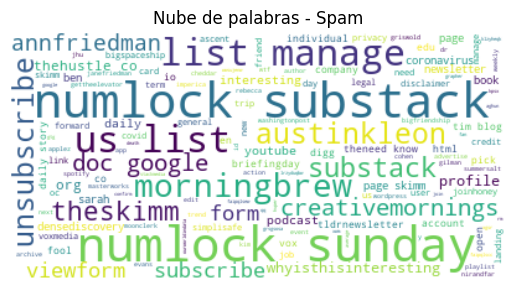

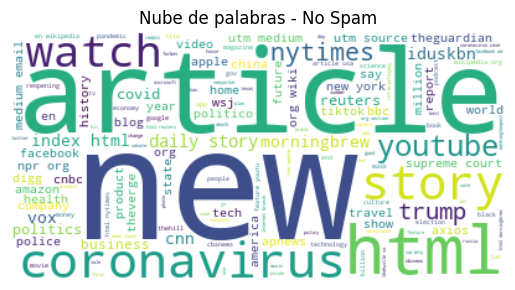

In [43]:
# Dividir en dos grupos según si es spam o no
spam_url = ' '.join(df_prepro[df_prepro['is_spam'] == 1]['url_prepro'])
no_spam_url = ' '.join(df_prepro[df_prepro['is_spam'] == 0]['url_prepro'])

wordcloud_spam = WordCloud(background_color = "white", max_words = 500, contour_color = "steelblue", collocations = True)
wordcloud_spam.generate(spam_url)
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis('off')
plt.title("Nube de palabras - Spam")
plt.show()

wordcloud_no_spam = WordCloud(background_color = "white", max_words = 500, contour_color = "steelblue", collocations = True)
wordcloud_no_spam.generate(no_spam_url)
plt.imshow(wordcloud_no_spam, interpolation='bilinear')
plt.axis('off')
plt.title("Nube de palabras - No Spam")
plt.show()

## Paso 6 - Partición:

In [44]:
X_train, X_test, y_train, y_test = train_test_split(df_prepro ['url_prepro'], df_prepro ['is_spam'], test_size=0.2, random_state=42);

## Paso 7 - Vectorizador:

In [26]:
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

## Paso 8 - Construcción del Modelo:

In [58]:
# Se comprueba cómo de balanceado se encuentra el conjunto de datos:
df_prepro['is_spam'].value_counts()

is_spam
0    2055
1     234
Name: count, dtype: int64

In [56]:
# Se define el modelo SVM: 
svm_model = SVC();

# Se define el espacio de búsqueda de hiperparámetros:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.1, 1]
};

# Se configura la malla de búsqueda, GridSearchCV:
grid_search = GridSearchCV(estimator = svm_model, param_grid = param_grid, cv = 5, verbose = 1, n_jobs = -1);

# Se ajusta el modelo con los datos de entrenamiento
grid_search.fit(X_train_vec, y_train);

# Se muestran los mejores hiperparámetros encontrados los mejores hiperparámetros encontrados
print(f"\n\nMejores hiperparámetros: {grid_search.best_params_}\n\n");

# Se guarda el mejor modelo:
best_grid_SVC= grid_search.best_estimator_;

# Se obtiene la predicción para el conjunto de test:
y_pred_grid = best_grid_SVC.predict(X_test_vec);

# Se imprimen las métricas:
print("\n Métricas de la Predicción:");
print(classification_report(y_test, y_pred_grid));
print(f" Exactitud: {round(100*accuracy_score(y_test, y_pred_grid), 2)} %");


Fitting 5 folds for each of 64 candidates, totalling 320 fits


Mejores hiperparámetros: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}



 Métricas de la Predicción:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       412
           1       0.62      0.63      0.62        46

    accuracy                           0.92       458
   macro avg       0.79      0.79      0.79       458
weighted avg       0.92      0.92      0.92       458

 Exactitud: 92.36 %


In [ ]:
# Se define el modelo SVM:
svm_model = SVC();

# Se define el espacio de búsqueda de hiperparámetros:
parameters = {
    'C': uniform(0.1, 1000),  
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  
    'gamma': ['scale', 'auto', uniform(0.01, 1)]  
};

# Se configura la búsqueda aleatoria, RandomizedSearchCV:
random_search = RandomizedSearchCV(estimator = svm_model, param_distributions = parameters, n_iter = 100, cv = 5, verbose = 1, random_state = 42, n_jobs = -1);

# Se ajusta el modelo con los datos de entrenamiento:
random_search.fit(X_train_vec, y_train);

# Se muestran los mejores hiperparámetros encontrados:
print(f"\n\nMejores hiperparámetros: {random_search.best_params_}\n\n");

# Se guarda el mejor modelo:
best_random_SVC = random_search.best_estimator_;

# Se obtiene la predicción para el conjunto de test:
y_pred_random = best_random_SVC.predict(X_test_vec);

# Se obtienen las métricas:
print("\n Métricas de la Predicción:");
print(classification_report(y_test, y_pred_random));
print(f"\nExactitud: {round(100 * accuracy_score(y_test, y_pred_random), 2)} %");

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/home/vscode/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
145 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/vscode/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vscode/.local/lib/python3.10/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/home/vscode/.local/lib/python3.10/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/home/vscode/.loca



Mejores hiperparámetros: {'C': np.float64(374.6401188473625), 'gamma': 'scale', 'kernel': 'rbf'}



 Métricas de la Predicción:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       412
           1       0.46      0.54      0.50        46

    accuracy                           0.89       458
   macro avg       0.71      0.74      0.72       458
weighted avg       0.90      0.89      0.89       458


Exactitud: 89.08 %
